In the following example, you will try to predict the vote of people during an election in the United Kingdom by knowing some information on their knowledge and political orientation.

## 0. Importing Libraries

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import metrics
import bisect

import warnings
warnings.filterwarnings('ignore')

##  1. Reading data

In [218]:
df = pd.read_csv("BEPS.csv")

In [219]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge,gender
0,Liberal Democrat,43,3,3,4,1,4,2,2,female
1,Labour,36,4,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,3,2,male
3,Labour,24,4,2,2,1,3,4,0,female
4,Labour,41,2,2,1,1,4,6,2,male


In [220]:
df.shape

(1525, 10)

In [221]:
df.describe()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000
mean,54.182295,3.245902,3.140328,3.334426,2.746885,3.135082,6.728525,1.542295
std,15.711209,0.880969,0.929951,1.174824,1.230703,1.081997,3.297538,1.083315
min,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,41.000000,3.000000,3.000000,2.000000,2.000000,2.000000,4.000000,0.000000
50%,53.000000,3.000000,3.000000,4.000000,2.000000,3.000000,6.000000,2.000000
75%,67.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.000000,2.000000
max,93.000000,5.000000,5.000000,5.000000,5.000000,5.000000,11.000000,3.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contain any missing values.

In [222]:
df.isna().sum(axis=0)

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Kennedy                    0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

### 2.2. Distribution of the target variable

Plot the distribution of the target variable.

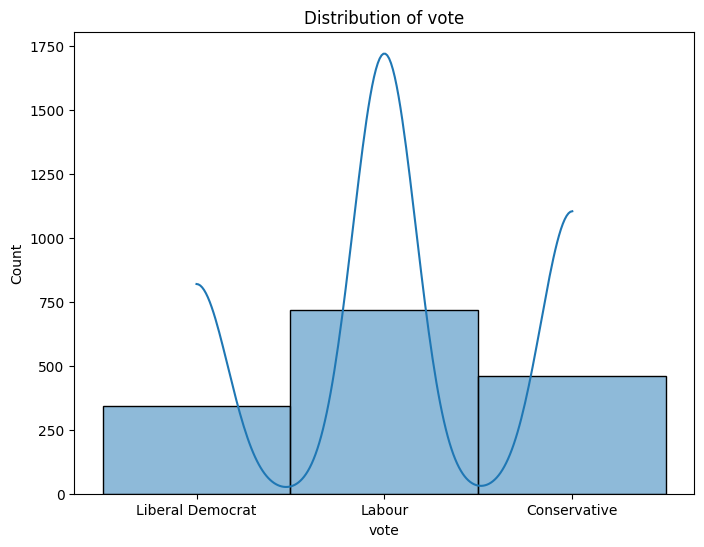

In [223]:
# Plotting a histogram of the vote
plt.figure(figsize=(8, 6))
sns.histplot(df['vote'], kde=True, edgecolor='black')
plt.title('Distribution of vote')
plt.xlabel('vote')
plt.ylabel('Count')
plt.show()

### 2.3. Distribution of numerical variables

Plot the distribution of the numerical features.

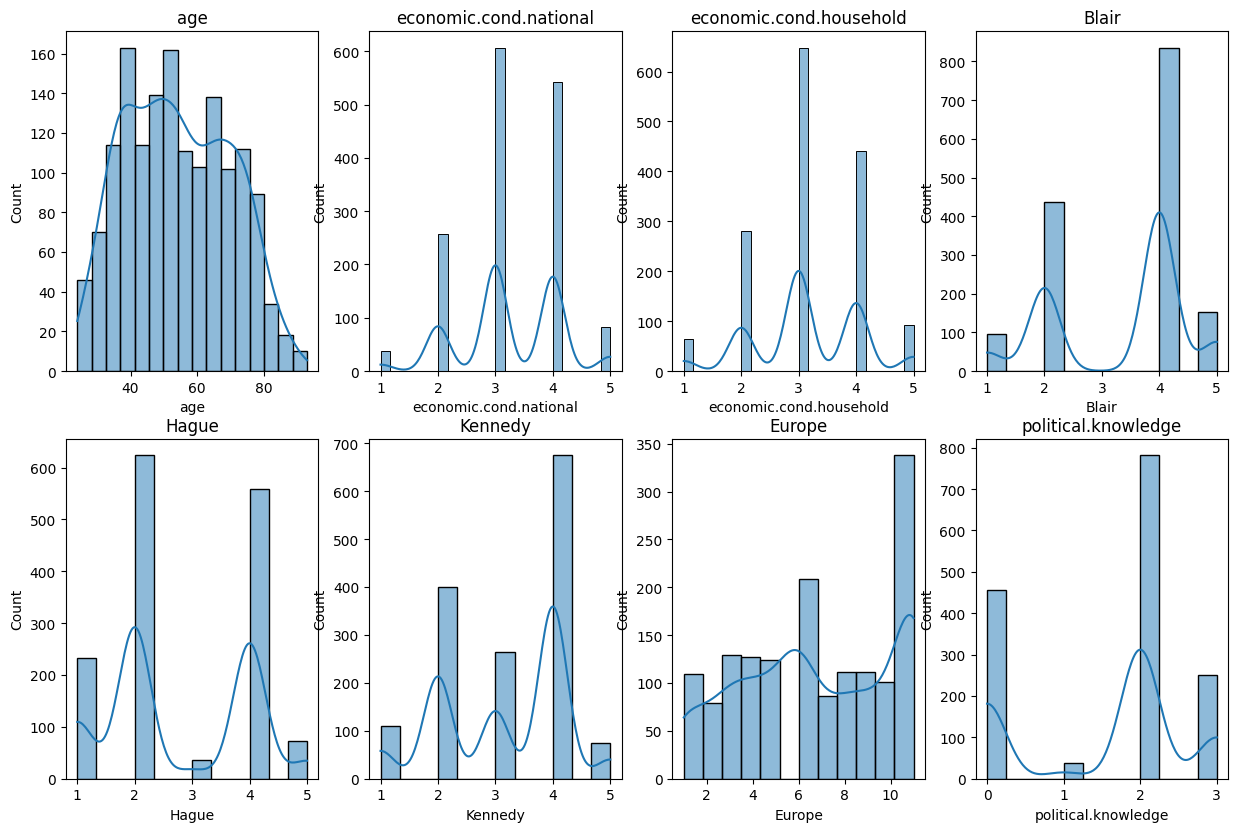

In [224]:
# numerical columns
numerical_columns = df.dtypes[(df.dtypes=="int64")].index.values.tolist()

# Plotting the distribution of numerical features
plt.figure(figsize=(15, 15))
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(3, 4, i)
    sns.histplot(df[column], kde=True, edgecolor='black')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Count')



plt.show()


### 2.4. Histogram of catagorical variables

Plot the histogram of the catagorical features.

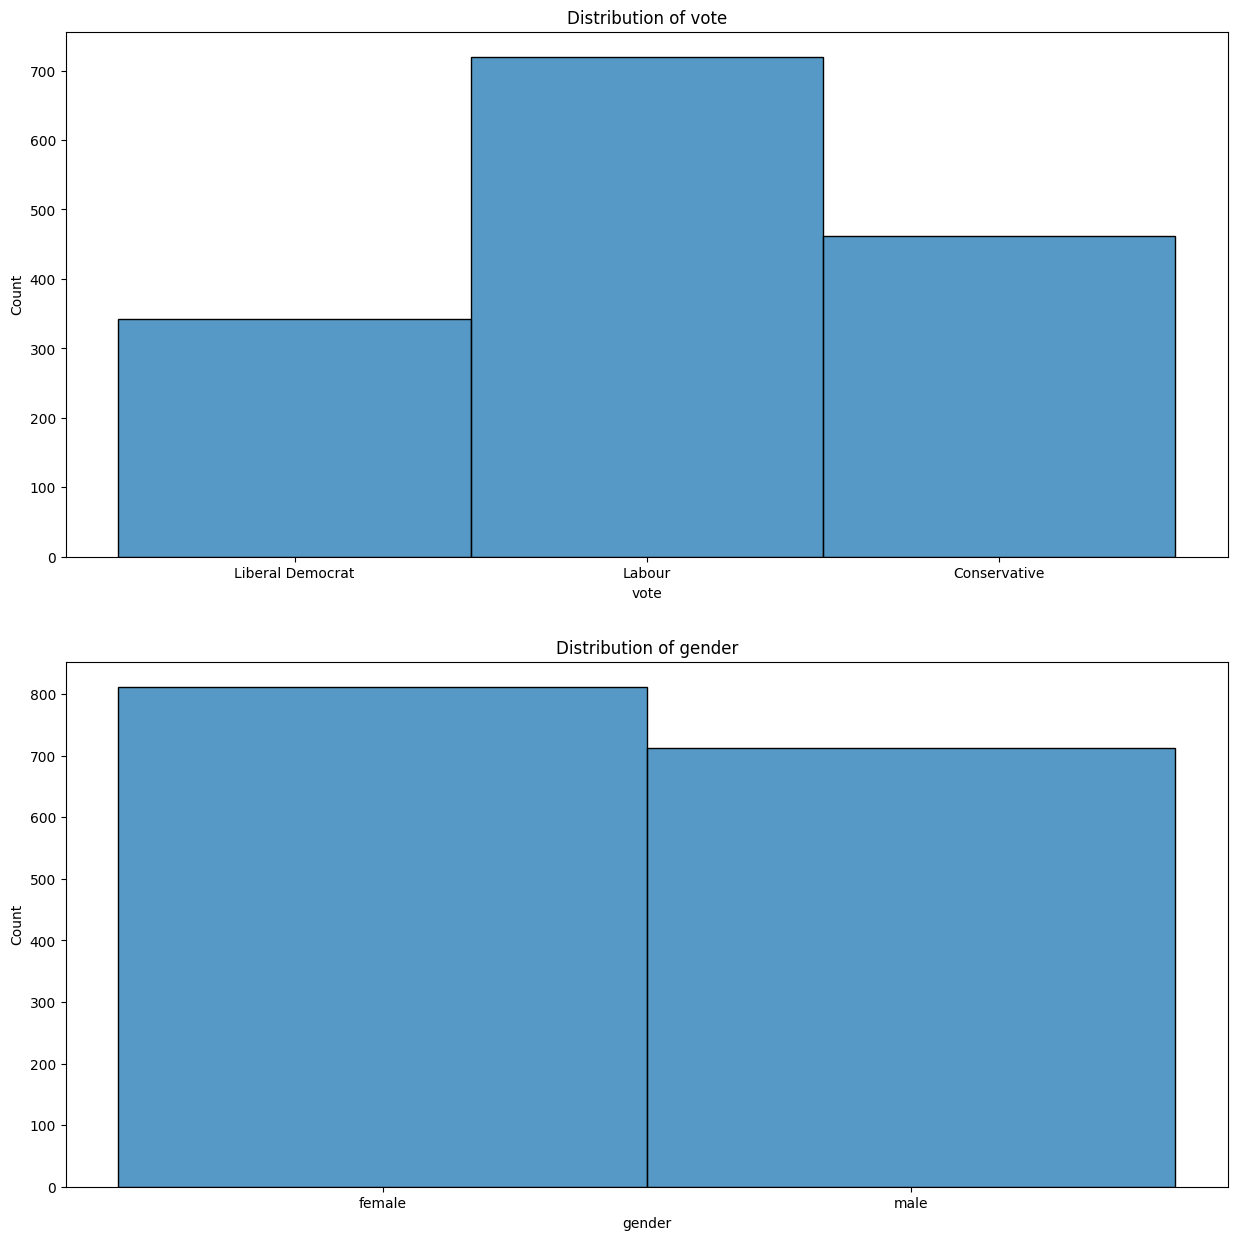

In [225]:
# Selecting only categorical columns for visualization
categorical_columns = df.select_dtypes(include='object').columns

# Plotting the distribution of categorical features
plt.figure(figsize=(15, 15))
for i, column in enumerate(categorical_columns, start=1):
    plt.subplot(len(categorical_columns), 1, i)
    sns.histplot(df[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.show()

## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [226]:
X = df.drop('vote', axis=1)  # Features
y = df['vote']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1220, 9)
(1220,)
(305, 9)
(305,)


## 4. Feature Engineering

### 4.1. Scaling numerical variables

In [227]:
#numerical_columns = df.dtypes[df.dtypes == "int64"].index.values.tolist()

scaler = StandardScaler()

# Fit and transform the scaler for the training data 
# Transform the test data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Display the scaled datasets
print("Scaled X_train:")
print(X_train.head())

print("\nScaled X_test:")
print(X_test.head())

Scaled X_train:
          age  economic.cond.national  economic.cond.household     Blair  \
196 -0.011923               -0.281403                 2.040362 -1.151954   
739  1.569152                0.870650                 2.040362  1.407943   
602  0.177806               -0.281403                 0.951931  0.554644   
106  0.810236                0.870650                -0.136500  0.554644   
75  -0.075166                0.870650                 0.951931  0.554644   

        Hague   Kennedy    Europe  political.knowledge  gender  
196  1.035377 -1.031210  1.303931             0.415609  female  
739  0.222009 -0.116246  0.086097            -0.499631  female  
602 -0.591358  0.798719 -0.218362            -1.414872  female  
106 -0.591358 -1.031210 -0.827279            -1.414872    male  
75  -0.591358  0.798719 -0.522820             1.330850    male  

Scaled X_test:
           age  economic.cond.national  economic.cond.household     Blair  \
1000  1.316180                0.870650      

### 4.2. Catagorical variables encoding

Convert catagorical columns into numerical columns using label encoding or one hot encoding.

In [228]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
categorical_columns.remove('vote') 

le = LabelEncoder()

for column in categorical_columns:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])

# Display the datasets with label-encoded categorical columns
print("Label Encoded X_train:")
print(X_train.head())

print("\nLabel Encoded X_test:")
print(X_test.head())

Label Encoded X_train:
          age  economic.cond.national  economic.cond.household     Blair  \
196 -0.011923               -0.281403                 2.040362 -1.151954   
739  1.569152                0.870650                 2.040362  1.407943   
602  0.177806               -0.281403                 0.951931  0.554644   
106  0.810236                0.870650                -0.136500  0.554644   
75  -0.075166                0.870650                 0.951931  0.554644   

        Hague   Kennedy    Europe  political.knowledge  gender  
196  1.035377 -1.031210  1.303931             0.415609       0  
739  0.222009 -0.116246  0.086097            -0.499631       0  
602 -0.591358  0.798719 -0.218362            -1.414872       0  
106 -0.591358 -1.031210 -0.827279            -1.414872       1  
75  -0.591358  0.798719 -0.522820             1.330850       1  

Label Encoded X_test:
           age  economic.cond.national  economic.cond.household     Blair  \
1000  1.316180                

## 5. Logistic Regression

Fit a logistic regression model on the training set. Evaluate the model on the testing set. Use the F1score as an evaluation metric.

In [229]:
# Create a Logistic Regression model
logR = LogisticRegression(random_state=42, fit_intercept=True)

# Train using the training dataset
logR.fit(X_train, y_train)

# Predict over testing datasets
y_test_pred = logR.predict(X_test)

# Calculate and display F1 score for each class
f1 = metrics.f1_score(y_test, y_test_pred, average=None)

for i, score in enumerate(f1):
    print(f"F1 Score for Class {i}: {score:.4f}")


F1 Score for Class 0: 0.6798
F1 Score for Class 1: 0.7395
F1 Score for Class 2: 0.2292


## 6. Decision Tree

Fit a decision tree model on the training set. Use cross-validation in order to tune the hyperparameters of the decision tree model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

In [230]:
# Initialize Decision Tree model with default hyperparameters
DecTree = DecisionTreeClassifier(criterion='gini', max_depth=4)

# Train Decision Tree Classifier
DecTree.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = DecTree.predict(X_test)

# Define hyperparameters to tune
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [5, 10, 15, 20, 50],
              'min_samples_leaf': [5, 10, 15, 20, 50]}

# Use Macro F1 score as the evaluation metric
search = RandomizedSearchCV(DecTree, param_distributions=param_grid, scoring='f1_macro', cv=5, n_iter=400)
search.fit(X_train, y_train)

# Get the best hyperparameters
DecTree = search.best_estimator_

# Evaluate the best model on the testing set
y_test_pred = DecTree.predict(X_test)
f1_macro_dt = metrics.f1_score(y_test, y_test_pred, average='macro')

# Print the Macro F1 score
print("Macro F1 Score (Decision Tree):", f1_macro_dt)

Macro F1 Score (Decision Tree): 0.5299686000148219


Plot the decision tree.

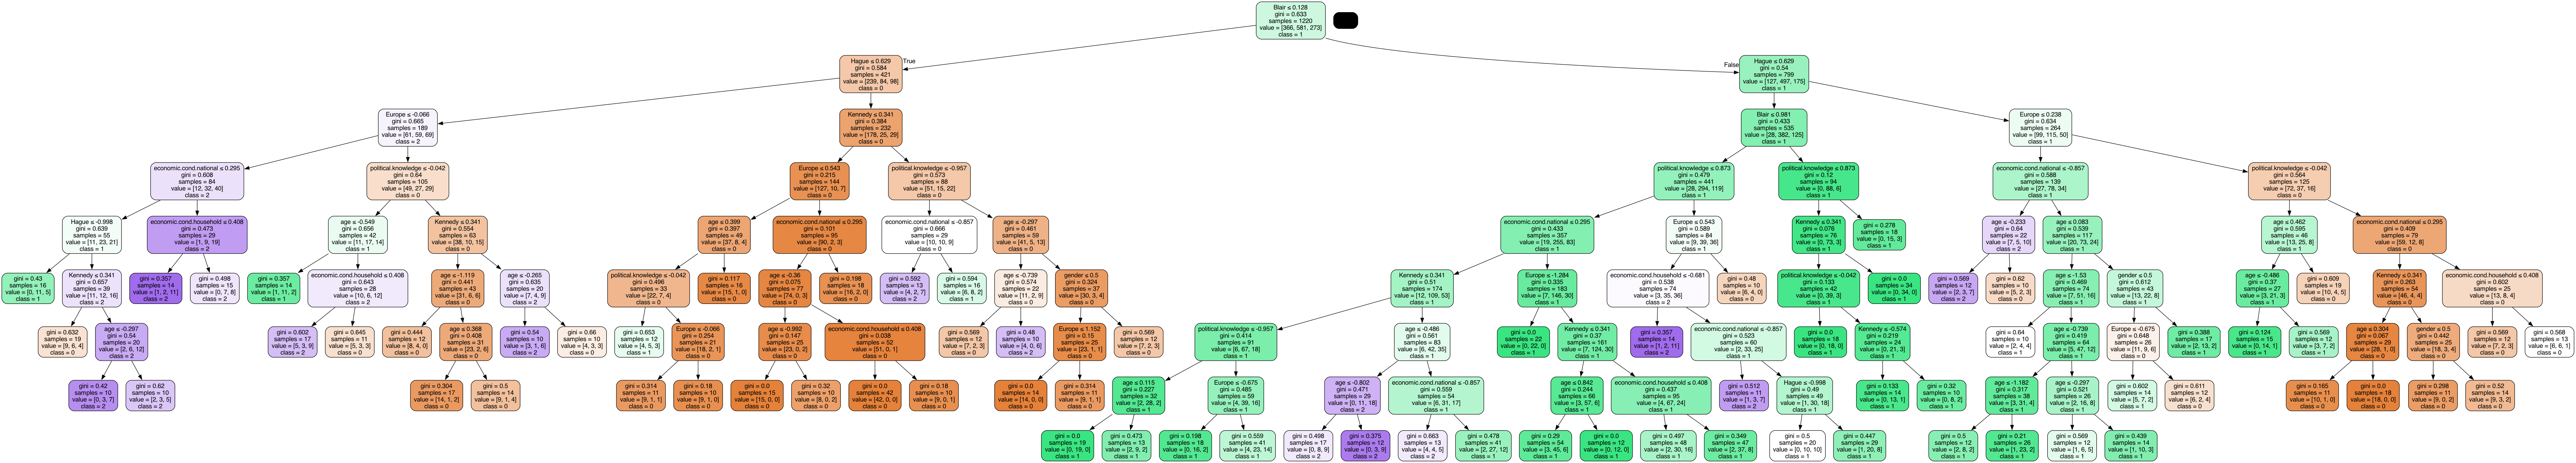

In [231]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(DecTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns, class_names=['0', '1', '2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('safety_distance.png')
Image(graph.create_png())

## 7. Random Forest

Fit a random forest model on the training set. Use cross-validation in order to tune the hyperparameters of the random forest model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

In [232]:
# Initialize Random Forest model with default hyperparameters
rf = RandomForestClassifier(criterion="gini", random_state=0)

# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

# Use Macro F1 score as the evaluation metric
search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='f1_macro', n_iter = 10, cv = 3, verbose=1, random_state=0)
search.fit(X_train, y_train)

# Get the best hyperparameters
rf = search.best_estimator_

# Evaluate the best model on the testing set
y_test_pred = rf.predict(X_test)
f1_macro_rf = metrics.f1_score(y_test, y_test_pred, average='macro')

# Print the Macro F1 score
print("Macro F1 Score (Random Forest):", f1_macro_rf)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Macro F1 Score (Random Forest): 0.5616596068208971


Plot feature importance/weight.

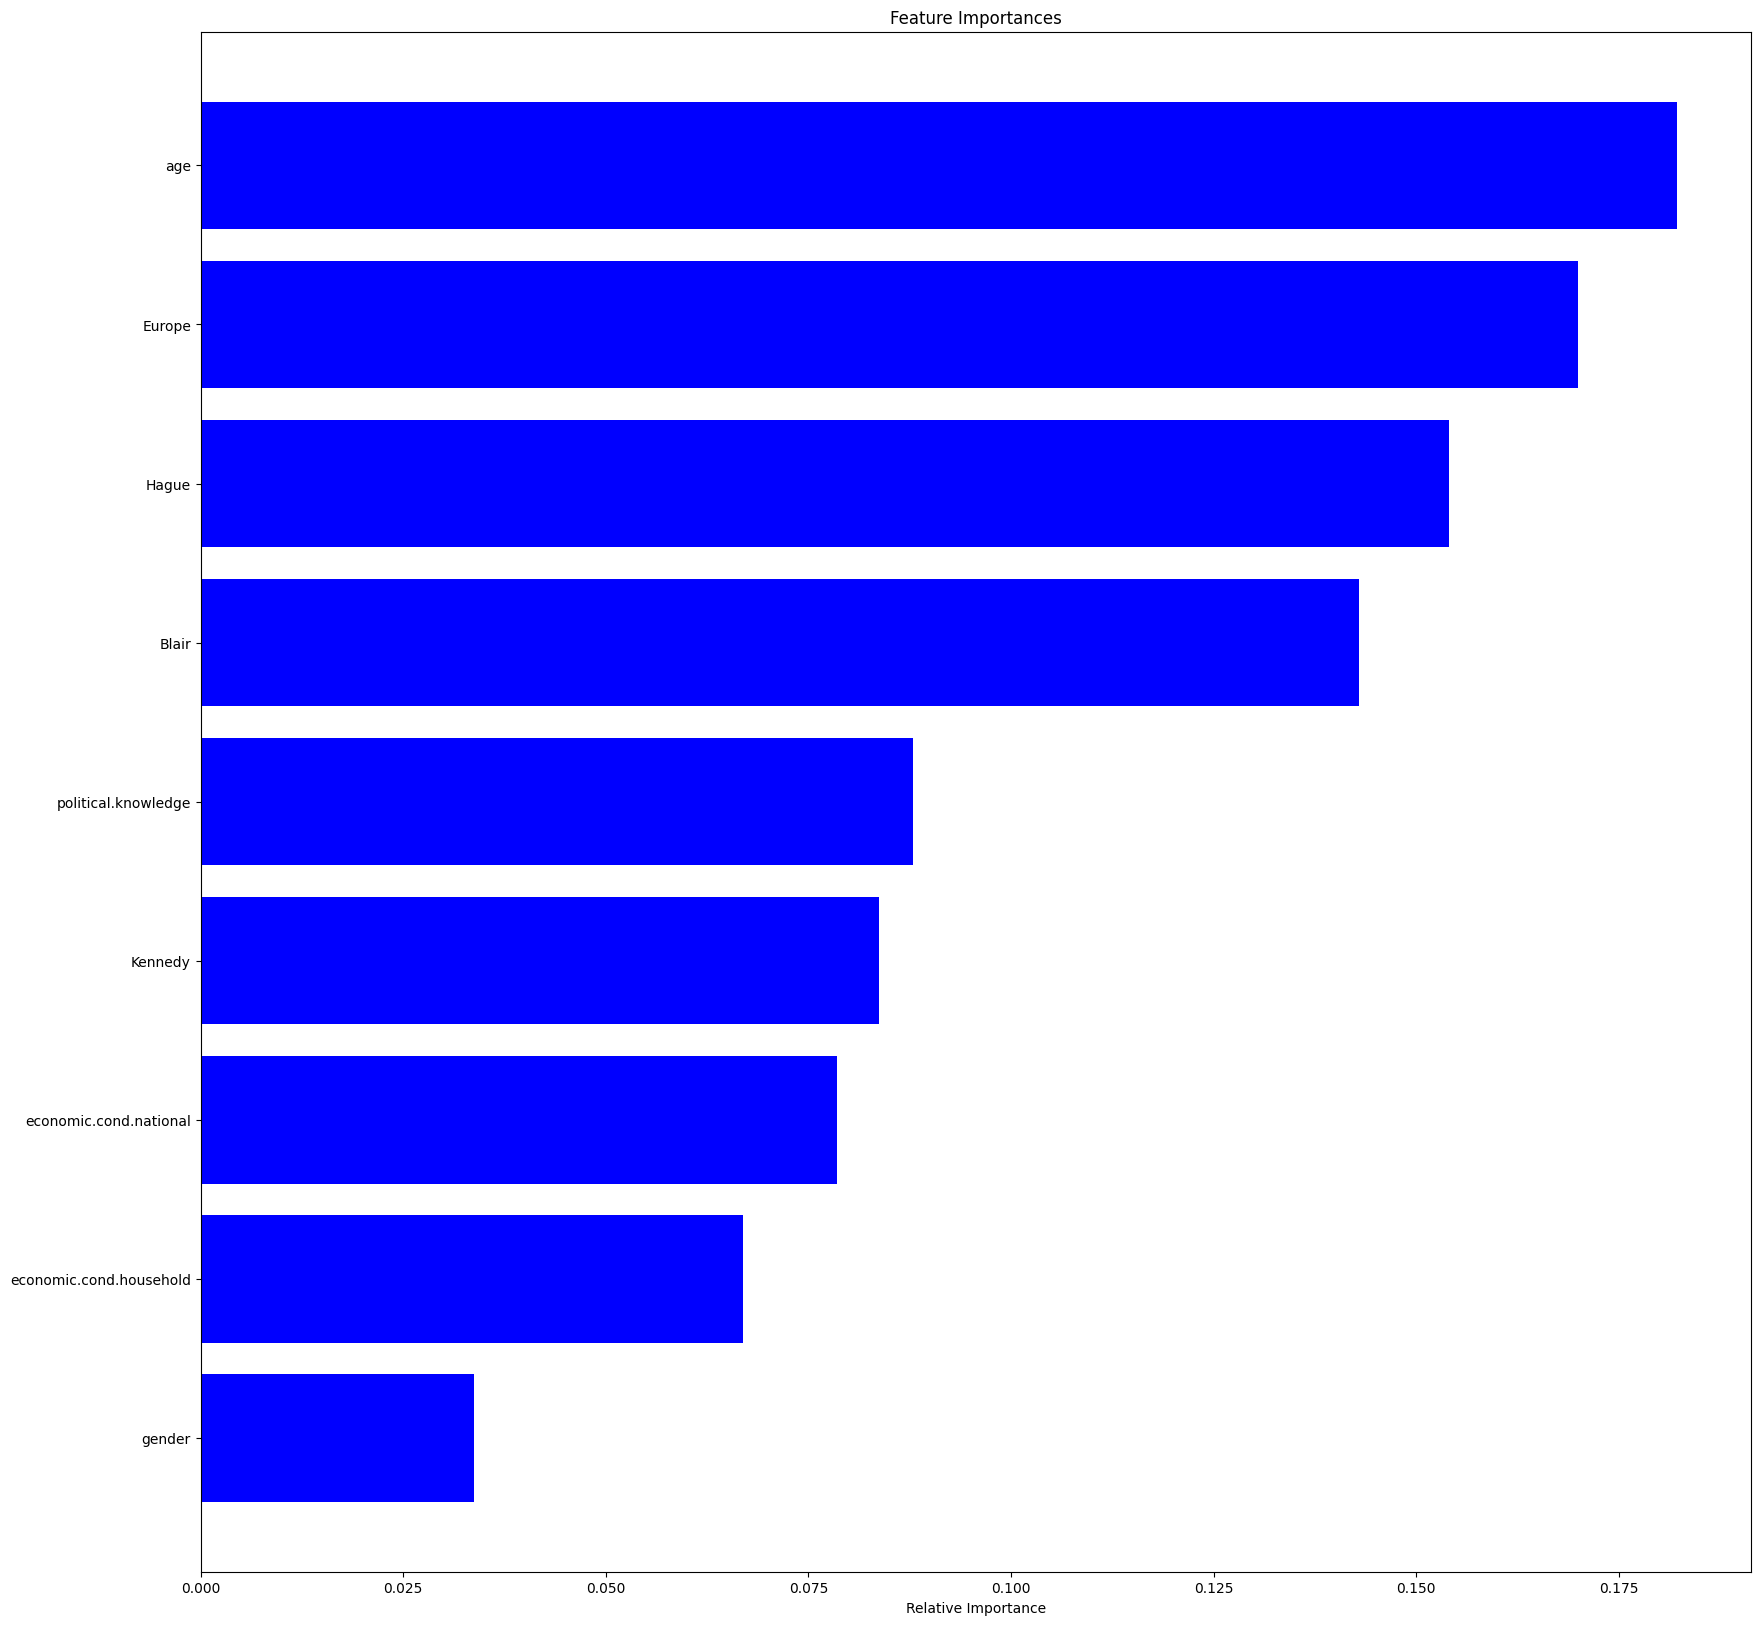

In [233]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 8. Gradient Boosting

Fit a gradient boosting model on the training set. Use cross-validation in order to tune the hyperparameters of the gradient boosting model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

In [234]:
# Initialize Gradient Boosting model with default hyperparameters
gb = GradientBoostingClassifier(random_state=0)

# Define hyperparameters to tune
param_grid = { 'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'learning_rate': [0.1, 1],
               'subsample': [0.5, 0.7, 0.9]}

# Use Macro F1 score as the evaluation metric
search = RandomizedSearchCV(estimator = gb, param_distributions = param_grid, scoring='f1_macro', n_iter = 10, cv = 3, verbose=1, random_state=0)
search.fit(X_train, y_train)

# Get the best hyperparameters
gb = search.best_estimator_

# Evaluate the best model on the testing set
y_test_pred = gb.predict(X_test)
f1_macro_gb = metrics.f1_score(y_test, y_test_pred, average='macro')

# Print the Macro F1 score
print("Macro F1 Score (Gradient Boosting):", f1_macro_gb)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Macro F1 Score (Gradient Boosting): 0.562796110415158


Plot feature importance/weight.

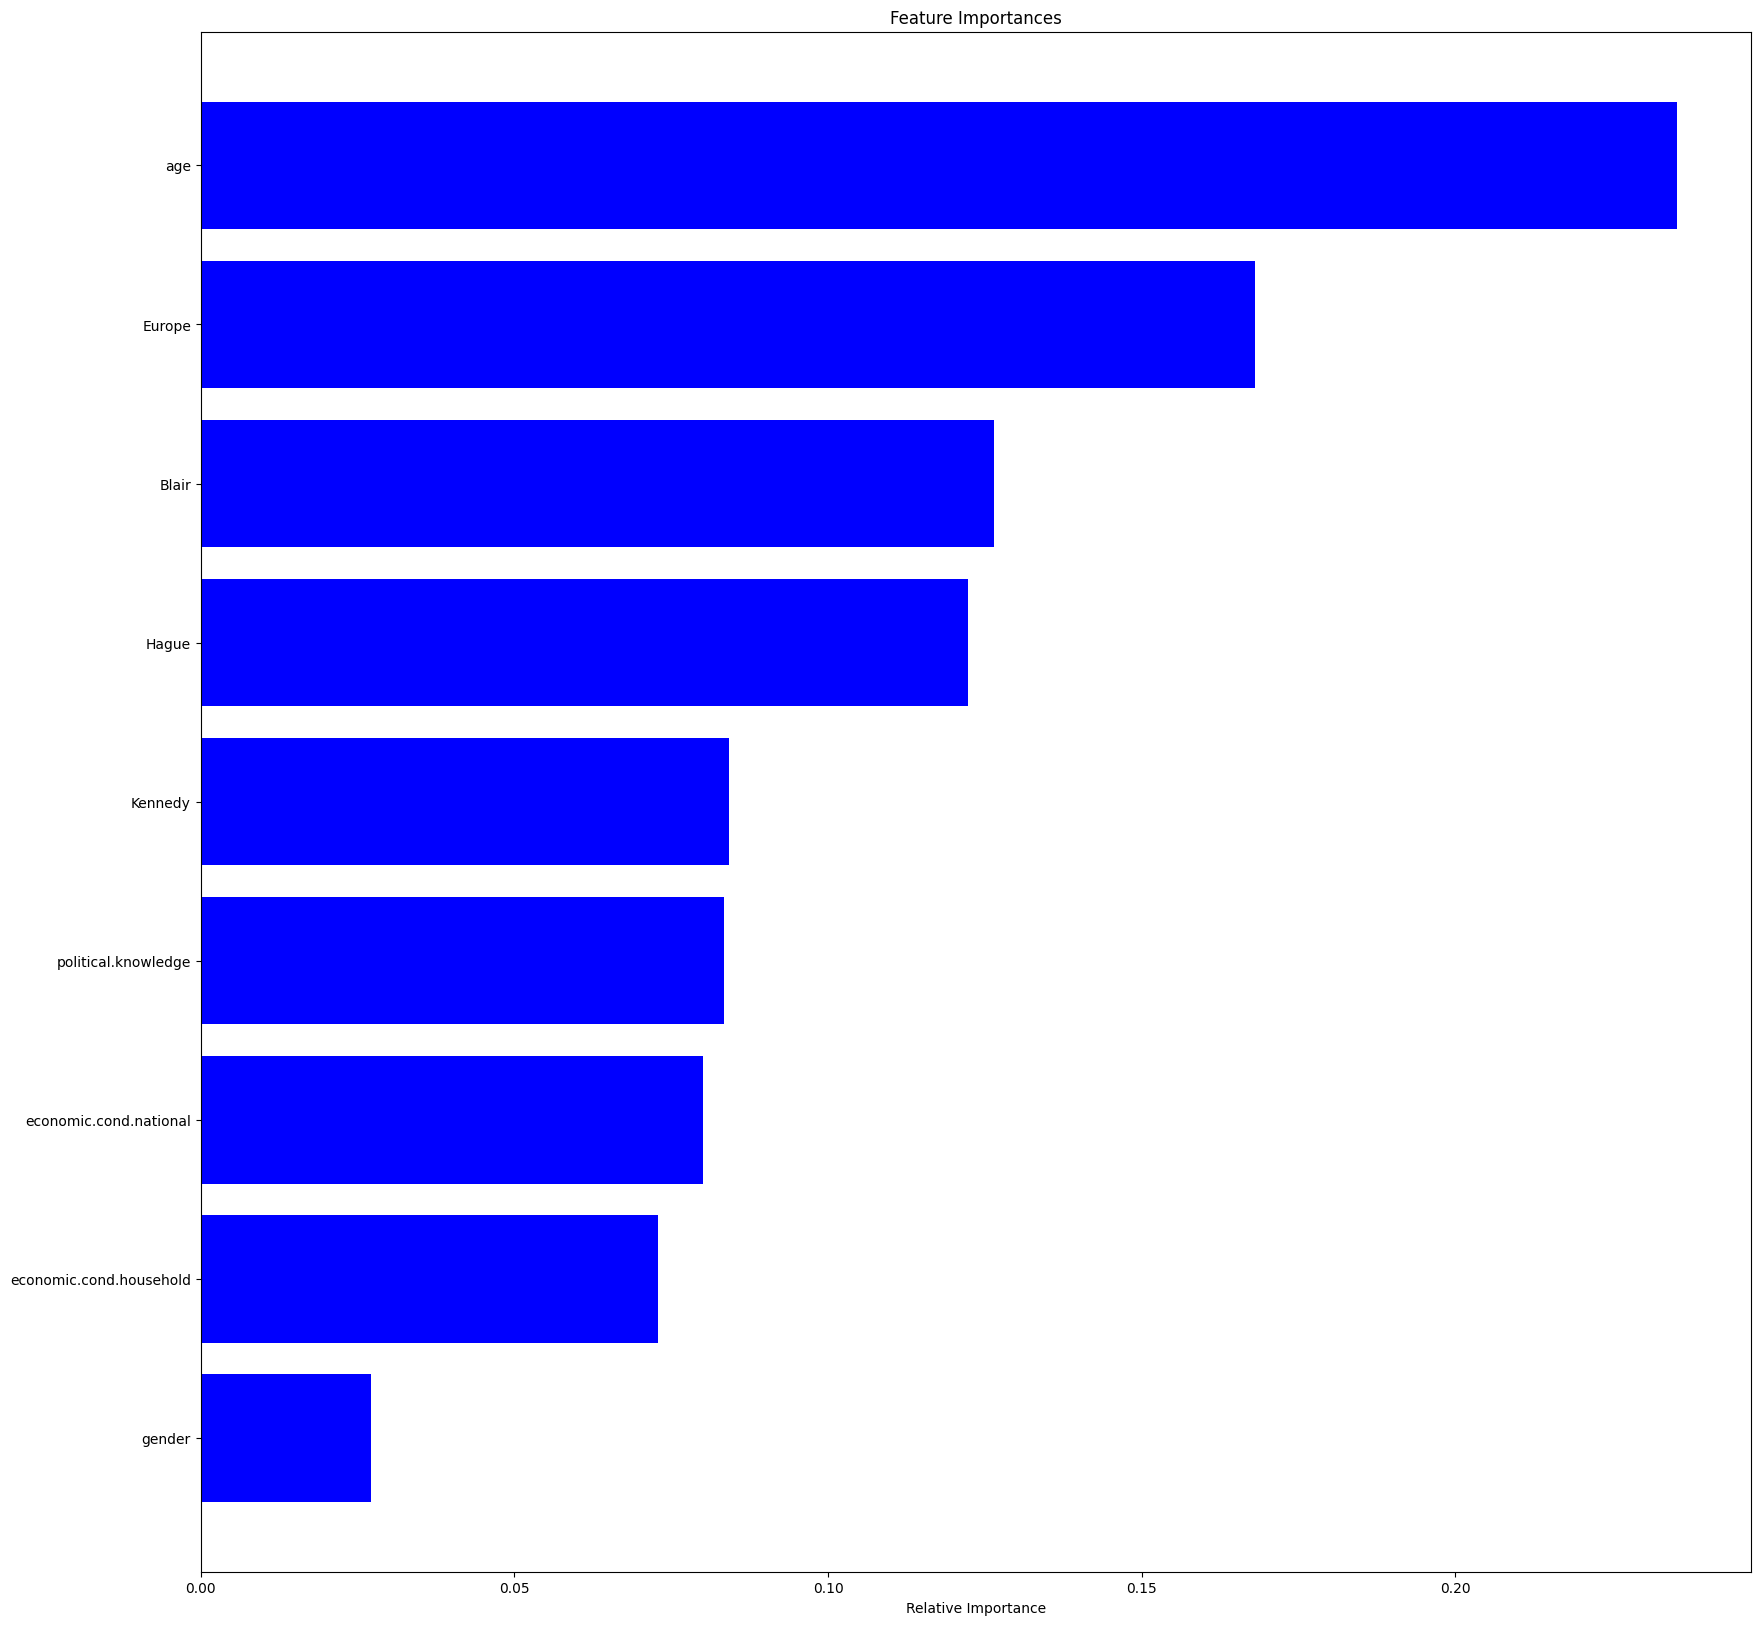

In [235]:
features = X_train.columns
importances = gb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()